<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC2_FD002_MLP_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%pip install scikeras;
%pip install -U tensorflow-addons;

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import shap

H:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from datetime import datetime

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.base import BaseEstimator,RegressorMixin

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

from keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare as R2



from scikeras.wrappers import KerasRegressor

In [7]:
sns.set_palette('colorblind')

In [8]:
# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
tf.config.experimental.enable_op_determinism()

# Data Preparation

In [10]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    IN_COLAB = True
    folder="/content/CMaps/"

    # Dataset Download 
    os.system('git clone https://github.com/arthursl12/dataset_2')
    os.system('mv /content/dataset_2/CMaps /content/CMaps')
    os.system('mv /content/dataset_2/data_processing /content/data_processing')
    os.system('rm -rf dataset_2')
else:
    print('Not running on CoLab')
    IN_COLAB = False
    folder="CMaps/"
    %cd dataset_2/

Not running on CoLab
C:\Users\Arthur Lima\POC\dataset_2


In [11]:
from data_processing.processing import DatasetProcessing
from data_processing.training import HyperparameterSearch, reclipper_scorer
from data_processing.eval import Evaluation

In [12]:
proc = DatasetProcessing()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [13]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(2,folder=folder)
train

unit_number  time     op_1    op_2   op_3     s_0     s_1      s_2  \
0                1     1  34.9983  0.8400  100.0  449.44  555.32  1358.61   
1                1     2  41.9982  0.8408  100.0  445.00  549.90  1353.22   
2                1     3  24.9988  0.6218   60.0  462.54  537.31  1256.76   
3                1     4  42.0077  0.8416  100.0  445.00  549.51  1354.03   
4                1     5  25.0005  0.6203   60.0  462.54  537.07  1257.71   
...            ...   ...      ...     ...    ...     ...     ...      ...   
53754          260   312  20.0037  0.7000  100.0  491.19  608.79  1495.60   
53755          260   313  10.0022  0.2510  100.0  489.05  605.81  1514.32   
53756          260   314  25.0041  0.6200   60.0  462.54  537.48  1276.24   
53757          260   315  25.0033  0.6220   60.0  462.54  537.84  1272.95   
53758          260   316  35.0036  0.8400  100.0  449.44  556.64  1374.61   

           s_3    s_4  ...    s_11     s_12     s_13     s_14  s_15  s_16  \
0      1137.23   5.48  ...  183.06  2387.72  8048.56   9.3461  0.02   334   
1      1125.78   3.91  ...  130.42  2387.66  8072.30   9.3774  0.02   330   
2      1047.45   7.05  ...  164.22  2028.03  7864.87  10.8941  0.02   309   
3      1126.38   3.91  ...  130.72  2387.61  8068.66   9.3528  0.02   329   
4      1047.93   7.05  ...  164.31  2028.00  7861.23  10.8963  0.02   309   
...        ...    ...  ...     ...      ...      ...      ...   ...   ...   
53754  1269.51   9.35  ...  314.05  2389.02  8169.64   9.3035  0.03   369   
53755  1324.12  10.52  ...  371.22  2388.42  8245.36   8.7586  0.03   374   
53756  1057.92   7.05  ...  163.74  2030.33  7971.25  11.0657  0.02   310   
53757  1066.30   7.05  ...  164.37  2030.35  7972.47  11.0537  0.02   311   
53758  1145.52   5.48  ...  183.09  2390.38  8185.35   9.3998  0.02   338   

       s_17    s_18   s_19     s_20  
0      2223  100.00  14.73   8.8071  
1      2212  100.00  10.41   6.2665  
2      1915   84.93  14.08   8.6723  
3      2212  100.00  10.59   6.4701  
4      1915   84.93  14.13   8.5286  
...     ...     ...    ...      ...  
53754  2324  100.00  24.36  14.5189  
53755  2319  100.00  28.10  16.9454  
53756  1915   84.93  14.19   8.5503  
53757  1915   84.93  14.05   8.3729  
53758  2223  100.00  14.75   8.8446  

[53759 rows x 26 columns]

## Preprocessing

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [14]:
test.shape, y_test.shape

((33991, 26), (259, 1))

In [15]:
test_last = proc.transform_test_keep_setting(test)
test_last.head()

op_1    op_2   op_3     s_0     s_1      s_2      s_3    s_4    s_5  \
0  10.0076  0.2501  100.0  489.05  605.42  1515.00  1325.07  10.52  15.50   
1   0.0018  0.0000  100.0  518.67  642.67  1591.67  1418.17  14.62  21.61   
2  35.0015  0.8412  100.0  449.44  555.86  1370.62  1135.59   5.48   8.00   
3  20.0032  0.7000  100.0  491.19  607.99  1487.94  1257.49   9.35  13.66   
4  42.0055  0.8400  100.0  445.00  550.81  1358.95  1140.34   3.91   5.72   

      s_6  ...    s_11     s_12     s_13    s_14  s_15  s_16  s_17   s_18  \
0  393.58  ...  370.87  2388.32  8167.06  8.7456  0.03   371  2319  100.0   
1  553.36  ...  521.10  2388.12  8138.12  8.4248  0.03   393  2388  100.0   
2  194.58  ...  183.11  2388.07  8071.23  9.3094  0.02   332  2223  100.0   
3  334.39  ...  314.88  2388.12  8062.39  9.2349  0.02   365  2324  100.0   
4  138.42  ...  130.82  2389.06  8140.94  9.3964  0.02   333  2212  100.0   

    s_19     s_20  
0  28.30  17.0934  
1  38.82  23.3463  
2  14.75   8.9589  
3  24.22  14.6814  
4  10.34   6.3601  

[5 rows x 24 columns]

In [16]:
X_test = test_last

### Remaining Useful Life (RUL)

In [17]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

unit_number  time  RUL
0            1     1  148
1            1     2  147
2            1     3  146
3            1     4  145
4            1     5  144

## Attributes and target separation

In [18]:
X_train, y_train = proc.X_y_train_divide_with_settings(train)

In [19]:
y_train.head()

RUL
0  148
1  147
2  146
3  145
4  144

In [20]:
X_train.head()

op_1    op_2   op_3     s_0     s_1      s_2      s_3   s_4   s_5  \
0  34.9983  0.8400  100.0  449.44  555.32  1358.61  1137.23  5.48  8.00   
1  41.9982  0.8408  100.0  445.00  549.90  1353.22  1125.78  3.91  5.71   
2  24.9988  0.6218   60.0  462.54  537.31  1256.76  1047.45  7.05  9.02   
3  42.0077  0.8416  100.0  445.00  549.51  1354.03  1126.38  3.91  5.71   
4  25.0005  0.6203   60.0  462.54  537.07  1257.71  1047.93  7.05  9.03   

      s_6  ...    s_11     s_12     s_13     s_14  s_15  s_16  s_17    s_18  \
0  194.64  ...  183.06  2387.72  8048.56   9.3461  0.02   334  2223  100.00   
1  138.51  ...  130.42  2387.66  8072.30   9.3774  0.02   330  2212  100.00   
2  175.71  ...  164.22  2028.03  7864.87  10.8941  0.02   309  1915   84.93   
3  138.46  ...  130.72  2387.61  8068.66   9.3528  0.02   329  2212  100.00   
4  175.05  ...  164.31  2028.00  7861.23  10.8963  0.02   309  1915   84.93   

    s_19    s_20  
0  14.73  8.8071  
1  10.41  6.2665  
2  14.08  8.6723  
3  10.59  6.4701  
4  14.13  8.5286  

[5 rows x 24 columns]

## Training and Evaluation functions

In [21]:
eval = Evaluation()

In [22]:
search = HyperparameterSearch()

# Sensor Dictionary

In [23]:
sensor_dictionary = {
    "s_0": "T2 (s_0)",
    "s_1": "T24 (s_1)",
    "s_2": "T30 (s_2)",
    "s_3": "T50 (s_3)",
    "s_4": "P2 (s_4)",
    "s_5": "P15 (s_5)",
    "s_6": "P30 (s_6)",
    "s_7": "Nf (s_7)",
    "s_8": "Nc (s_8)",
    "s_9": "epr (s_9)",
    "s_10": "Ps30 (s_10)",
    "s_11": "phi (s_11)",
    "s_12": "NRf (s_12)",
    "s_13": "NRc (s_13)",
    "s_14": "BPR (s_14)",
    "s_15": "farB (s_15)",
    "s_16": "htBleed (s_16)",
    "s_17": "Nf_dmd (s_17)",
    "s_18": "PCNfR_dmd (s_18)",
    "s_19": "W31 (s_19)",
    "s_20": "W32 (s_20)"
}
sensor_dictionary.values()

dict_values(['T2 (s_0)', 'T24 (s_1)', 'T30 (s_2)', 'T50 (s_3)', 'P2 (s_4)', 'P15 (s_5)', 'P30 (s_6)', 'Nf (s_7)', 'Nc (s_8)', 'epr (s_9)', 'Ps30 (s_10)', 'phi (s_11)', 'NRf (s_12)', 'NRc (s_13)', 'BPR (s_14)', 'farB (s_15)', 'htBleed (s_16)', 'Nf_dmd (s_17)', 'PCNfR_dmd (s_18)', 'W31 (s_19)', 'W32 (s_20)'])

# MLP Construction

## Callbacks

In [24]:
# Early Stopping Callback
es = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                      patience=5, restore_best_weights=True)

In [25]:
# Printing Callback
def printLog(epoch, logs):
    print(
        f"E {epoch+1}\t: loss={logs['loss']:.3f}, "+
        f"rmse={logs['root_mean_squared_error']:.3f}, "+
        f"r2={logs['r_square']:.3f}; "+
        f"v_loss={logs['val_loss']:.3f}, "+
        f"v_rmse={logs['val_root_mean_squared_error']:.3f}, "+
        f"v_r2={logs['val_r_square']:.3f}; "
    )

printerCallback = LambdaCallback(on_epoch_end=printLog)

## Constants

In [26]:
# X_train must include indices
train3 = train.copy()
X_train_ = train3.drop(columns=[index_cols[1]]+["RUL"])

In [27]:
INPUT_SHAPE = 0

In [28]:
X_train_.columns = [index_cols[0]]+settings_cols+list(sensor_dictionary.values())
X_train_.columns

Index(['unit_number', 'op_1', 'op_2', 'op_3', 'T2 (s_0)', 'T24 (s_1)',
       'T30 (s_2)', 'T50 (s_3)', 'P2 (s_4)', 'P15 (s_5)', 'P30 (s_6)',
       'Nf (s_7)', 'Nc (s_8)', 'epr (s_9)', 'Ps30 (s_10)', 'phi (s_11)',
       'NRf (s_12)', 'NRc (s_13)', 'BPR (s_14)', 'farB (s_15)',
       'htBleed (s_16)', 'Nf_dmd (s_17)', 'PCNfR_dmd (s_18)', 'W31 (s_19)',
       'W32 (s_20)'],
      dtype='object')

In [29]:
sensors_cols = list(sensor_dictionary.values())

In [30]:
X_test.columns = settings_cols+list(sensor_dictionary.values())
X_test.columns

Index(['op_1', 'op_2', 'op_3', 'T2 (s_0)', 'T24 (s_1)', 'T30 (s_2)',
       'T50 (s_3)', 'P2 (s_4)', 'P15 (s_5)', 'P30 (s_6)', 'Nf (s_7)',
       'Nc (s_8)', 'epr (s_9)', 'Ps30 (s_10)', 'phi (s_11)', 'NRf (s_12)',
       'NRc (s_13)', 'BPR (s_14)', 'farB (s_15)', 'htBleed (s_16)',
       'Nf_dmd (s_17)', 'PCNfR_dmd (s_18)', 'W31 (s_19)', 'W32 (s_20)'],
      dtype='object')

## Wrapper

In [31]:
from sys import is_finalizing
from sklearn.metrics import r2_score

class MLPWrapperRegressor(BaseEstimator,RegressorMixin):
    def __init__(self, basemodel=None, clip_y=-1,
                 include_settings=False, poly_degree=1,
                 scaler=StandardScaler()):
        # Base parameters
        self.basemodel = basemodel
        self.clip_y = clip_y
        self.poly_degree = poly_degree
        self.include_settings = include_settings

        # Column indexers
        self.feature_cols = sensors_cols
        if(include_settings):
            self.feature_cols = settings_cols + self.feature_cols
        self.base_feature_cols = self.feature_cols

        # Scaler and PolyFeatures transformers
        self.scaler = scaler
        self.polyft = PolynomialFeatures(degree=self.poly_degree, 
                                         include_bias=False)

    def clean_cols(self,df):
        if("unit_number" in df.columns): del df["unit_number"]
        if("unit_number" in df.columns): del df["unit_number"]
        if("time" in df.columns): del df["time"]
        if((not self.include_settings)): 
            for col in settings_cols:
                if(col in df.columns): del df[col]
        return df

    def fit(self, X=None, y=None):
        # Drop irrelevant column
        data = pd.DataFrame(X).copy()
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.fit_transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.fit_transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        X_train = data.copy()
        
        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"]).copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_train = data2

        # Update input shape for future use
        global INPUT_SHAPE
        INPUT_SHAPE = X_train.shape[1]

        # Fit model
        self.basemodel.fit(X_train,y_train)
        return self
        
    def predict(self, X=None):
        # Perform transformation, if not done
        if (len(X.columns) != len(self.feature_cols)):
            X_train = self.transform_features(X)
        else:
            X_train = X
        return self.basemodel.predict(X_train)

    def transform_features(self, df):
        # Drop irrelevant column
        data = pd.DataFrame(df).copy()
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        # self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        return data

    def score(self, X, y, sample_weight=None):
        X_test = self.transform_features(X)

        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"]).copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_test = data2

        # Predict on test data
        y_pred = self.predict(X_test)
        return r2_score(y_test, y_pred, sample_weight=sample_weight)

## Test Data

In [32]:
def scale_test(test,model):
    test2 = pd.DataFrame(test)
    test2 = model.clean_cols(test2)

    # Apply polynomial features
    transf = model.polyft.transform(test2)
    test2 = pd.DataFrame(transf, 
                         columns=model.polyft.get_feature_names_out())

    # Scale the data (with train data parameters)
    test2 = model.scaler.transform(test2)
    test2 = pd.DataFrame(test2, 
                         columns=model.polyft.get_feature_names_out())
    return test2

## Constructor

In [33]:
def create_model(optim=Adam, learning_rate=1e-3, 
                 layer1=32  , activation1="tanh"    , dropout1=0.1,
                 layer2=None, activation2="tanh"    , dropout2=0.1,
                 layer3=None, activation3="tanh"    , dropout3=0.1,
                 layer4=None, activation4="tanh"    , dropout4=0.1,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Fully Connected Layer
    model.add(Dense(layer1, input_dim=INPUT_SHAPE, activation=activation1))
    model.add(Dropout(dropout1))

    # Additional hidden layers
    if(layer2 is not None):
        model.add(Dense(layer2, activation=activation2))
        model.add(Dropout(dropout2))
        if (layer3 is not None):
            model.add(Dense(layer3, activation=activation3))
            model.add(Dropout(dropout3))
            if (layer4 is not None):
                model.add(Dense(layer4, activation=activation4))
                model.add(Dropout(dropout4))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

# Model (ANN-3)

## Train

In [34]:
CLIP=80

model = MLPWrapperRegressor(
        clip_y=CLIP, scaler=StandardScaler(), poly_degree=1,
        include_settings=True,
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=130,
                        #    epochs=3,
                           epochs=47,
                           model__activation1='relu',
                           model__activation2='elu',
                           model__activation3='elu',
                           model__dropout1=0.6591215870708264, 
                           model__dropout2=0.3075952959408218, 
                           model__dropout3=0.3971628411684459, 
                           model__layer1=444, 
                           model__layer2=512, 
                           model__layer3=381,  
                           model__learning_rate=0.0035332717086087725,
                           model__optim=RMSprop,
                           validation_split=0.15776882704708337, 
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )
model

MLPWrapperRegressor(basemodel=KerasRegressor(batch_size=130, callbacks=[<keras.callbacks.EarlyStopping object at 0x000001595E926100>, <keras.callbacks.LambdaCallback object at 0x000001595DC18D30>], epochs=47, model=<function create_model at 0x000001595D1AD790>, model__activation1='relu', model__activation2='elu', model__activation3='elu', model__dropout1=0.65912158...te=0.0035332717086087725, model__loss='mse', model__metrics=[<keras.metrics.RootMeanSquaredError object at 0x000001595EBBBB20>, <tensorflow_addons.metrics.r_square.RSquare object at 0x000001595EBBBE50>], model__optim=<class 'keras.optimizer_v2.rmsprop.RMSprop'>, print_summary=True, validation_split=0.15776882704708337, verbose=0),
                    clip_y=80, include_settings=True)

In [35]:
model.fit(X_train_, y_train)
print("Finished:", datetime.now())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 444)               11100     
                                                                 
 dropout (Dropout)           (None, 444)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               227840    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 381)               195453    
                                                                 
 dropout_2 (Dropout)         (None, 381)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [36]:
# Scaling and formatting test data
test_sc = scale_test(X_test,model)

# Clipping test labels
reclipped_y = y_test.copy()
if(CLIP > 0): reclipped_y = reclipped_y["RUL"].clip(upper=CLIP, inplace=False)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_sc))
print("Finished:", datetime.now())

R2=0.780,RMSE=-13.128
Finished: 2022-11-08 06:29:56.507438


## Shap Values

In [37]:
X_train_

unit_number     op_1    op_2   op_3  T2 (s_0)  T24 (s_1)  T30 (s_2)  \
0                1  34.9983  0.8400  100.0    449.44     555.32    1358.61   
1                1  41.9982  0.8408  100.0    445.00     549.90    1353.22   
2                1  24.9988  0.6218   60.0    462.54     537.31    1256.76   
3                1  42.0077  0.8416  100.0    445.00     549.51    1354.03   
4                1  25.0005  0.6203   60.0    462.54     537.07    1257.71   
...            ...      ...     ...    ...       ...        ...        ...   
53754          260  20.0037  0.7000  100.0    491.19     608.79    1495.60   
53755          260  10.0022  0.2510  100.0    489.05     605.81    1514.32   
53756          260  25.0041  0.6200   60.0    462.54     537.48    1276.24   
53757          260  25.0033  0.6220   60.0    462.54     537.84    1272.95   
53758          260  35.0036  0.8400  100.0    449.44     556.64    1374.61   

       T50 (s_3)  P2 (s_4)  P15 (s_5)  ...  phi (s_11)  NRf (s_12)  \
0        1137.23      5.48       8.00  ...      183.06     2387.72   
1        1125.78      3.91       5.71  ...      130.42     2387.66   
2        1047.45      7.05       9.02  ...      164.22     2028.03   
3        1126.38      3.91       5.71  ...      130.72     2387.61   
4        1047.93      7.05       9.03  ...      164.31     2028.00   
...          ...       ...        ...  ...         ...         ...   
53754    1269.51      9.35      13.66  ...      314.05     2389.02   
53755    1324.12     10.52      15.50  ...      371.22     2388.42   
53756    1057.92      7.05       9.04  ...      163.74     2030.33   
53757    1066.30      7.05       9.04  ...      164.37     2030.35   
53758    1145.52      5.48       8.01  ...      183.09     2390.38   

       NRc (s_13)  BPR (s_14)  farB (s_15)  htBleed (s_16)  Nf_dmd (s_17)  \
0         8048.56      9.3461         0.02             334           2223   
1         8072.30      9.3774         0.02             330           2212   
2         7864.87     10.8941         0.02             309           1915   
3         8068.66      9.3528         0.02             329           2212   
4         7861.23     10.8963         0.02             309           1915   
...           ...         ...          ...             ...            ...   
53754     8169.64      9.3035         0.03             369           2324   
53755     8245.36      8.7586         0.03             374           2319   
53756     7971.25     11.0657         0.02             310           1915   
53757     7972.47     11.0537         0.02             311           1915   
53758     8185.35      9.3998         0.02             338           2223   

       PCNfR_dmd (s_18)  W31 (s_19)  W32 (s_20)  
0                100.00       14.73      8.8071  
1                100.00       10.41      6.2665  
2                 84.93       14.08      8.6723  
3                100.00       10.59      6.4701  
4                 84.93       14.13      8.5286  
...                 ...         ...         ...  
53754            100.00       24.36     14.5189  
53755            100.00       28.10     16.9454  
53756             84.93       14.19      8.5503  
53757             84.93       14.05      8.3729  
53758            100.00       14.75      8.8446  

[53759 rows x 25 columns]

In [38]:
train_sc = scale_test(X_train_, model)
train_np = np.array(train_sc)
feature_names = train_sc.columns
explainer = shap.DeepExplainer(model.basemodel.model_, train_np)

# 1k: instant
# 6k: ~40s
# 21k (all): ~6min

shap_values = explainer.shap_values(train_np)
shap_values = shap_values[0]
explainer.expected_value = np.array(explainer.expected_value)
explainer.expected_value[0]

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


58.843227

In [39]:
shap_values.shape

(53759, 24)

OSError: ignored

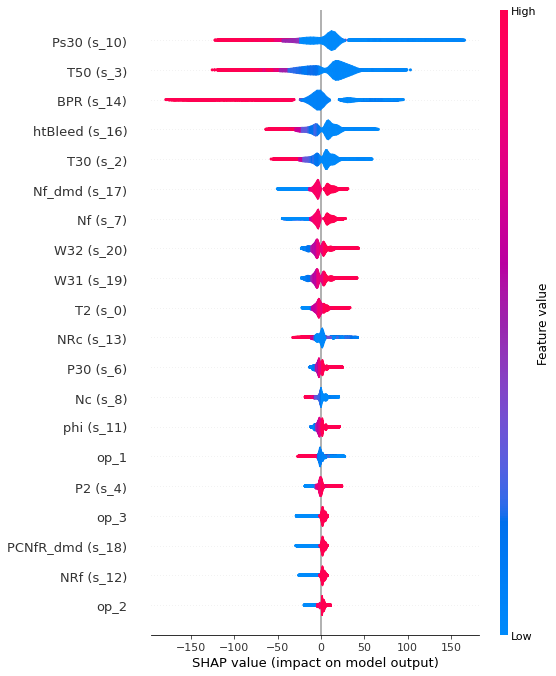

In [40]:
# shap.initjs()
shap.summary_plot(shap_values, train_np, plot_type="violin", 
                  feature_names=feature_names, show=False)
plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

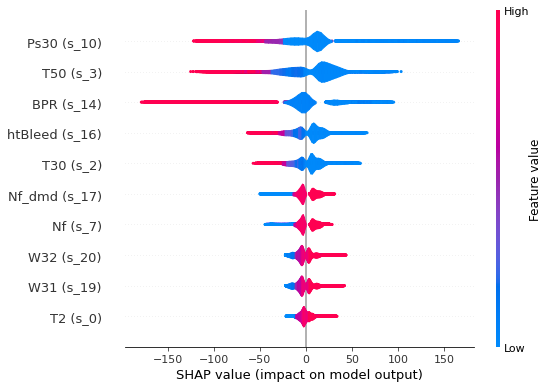

In [42]:
# shap.initjs()
shap.summary_plot(shap_values, train_np, plot_type="violin",max_display=10,
                  feature_names=feature_names, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

In [43]:
from scipy.ndimage import uniform_filter

def get_start_end(i, train=train):
    grouped = train.groupby("unit_number").count()["time"]
    start = np.sum(grouped[:i-1])
    end = start + grouped[i]
    return start,end

def shap_plot_unit(i, shap_values=shap_values, explainer=explainer, feature_names=feature_names, train=train, sma_window=0):
    shap.initjs()
    start,end = get_start_end(i,train)
    return shap.force_plot(explainer.expected_value, 
                    uniform_filter(shap_values[start:end], size=(sma_window,1), mode='nearest'), 
                    feature_names=feature_names)

In [44]:
shap_plot_unit(1)

In [45]:
shap_plot_unit(1,sma_window=5)

In [46]:
shap_plot_unit(32)

In [47]:
shap_plot_unit(32,sma_window=5)

In [48]:
shap_plot_unit(32,sma_window=10)

In [49]:
shap_plot_unit(32,sma_window=20)

In [50]:
shap_plot_unit(42)

In [51]:
shap_plot_unit(42,sma_window=10)

In [62]:
shap_plot_unit(42,sma_window=20)

In [52]:
get_start_end(42)

(8252, 8473)

In [72]:
filteded_42 = uniform_filter(shap_values[8252:8473], size=(20,1), mode='nearest')

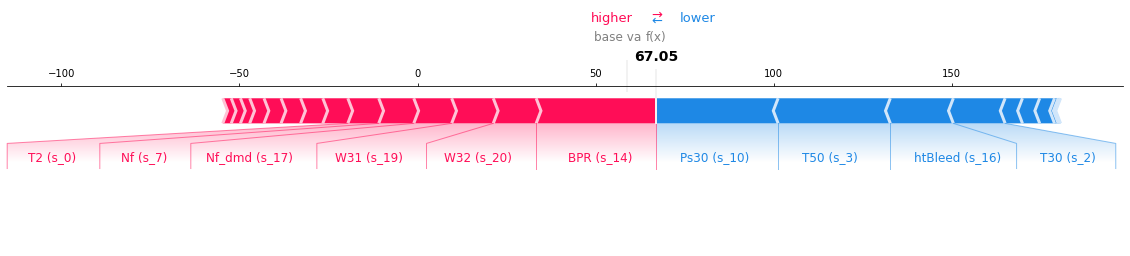

In [73]:
shap.force_plot(explainer.expected_value, filteded_42[0], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

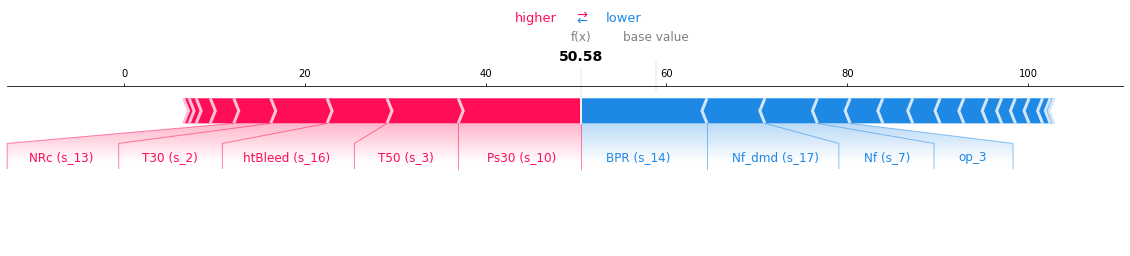

In [74]:
shap.force_plot(explainer.expected_value, filteded_42[150], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

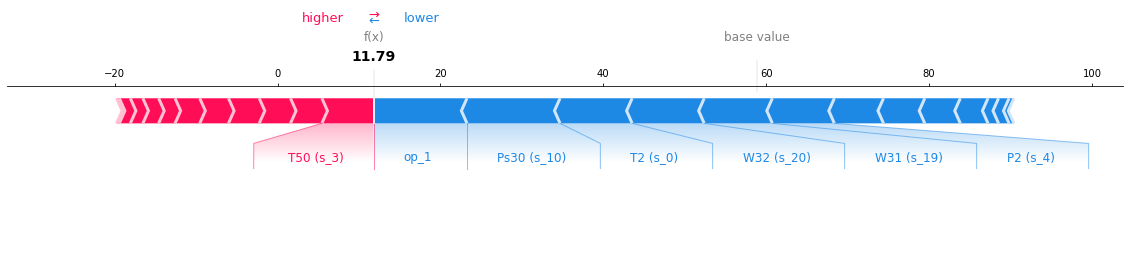

In [75]:
shap.force_plot(explainer.expected_value, filteded_42[-1], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

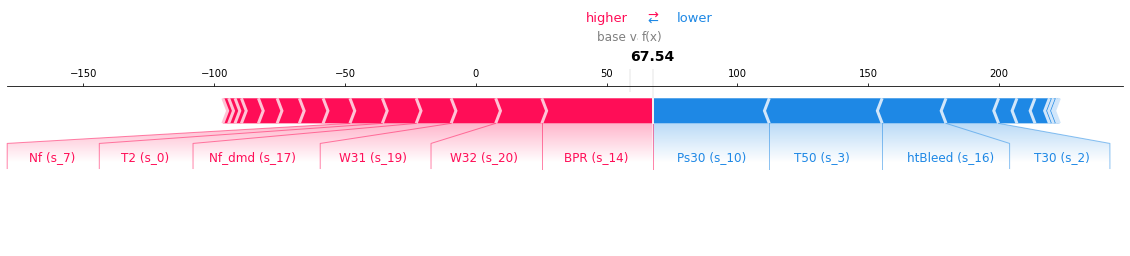

In [76]:
shap.force_plot(explainer.expected_value, shap_values[8252], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

In [84]:
8470-8252

218

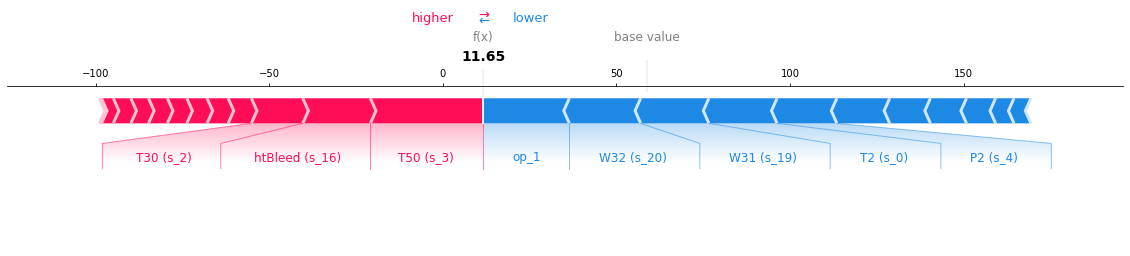

In [81]:
shap.force_plot(explainer.expected_value, shap_values[8470], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

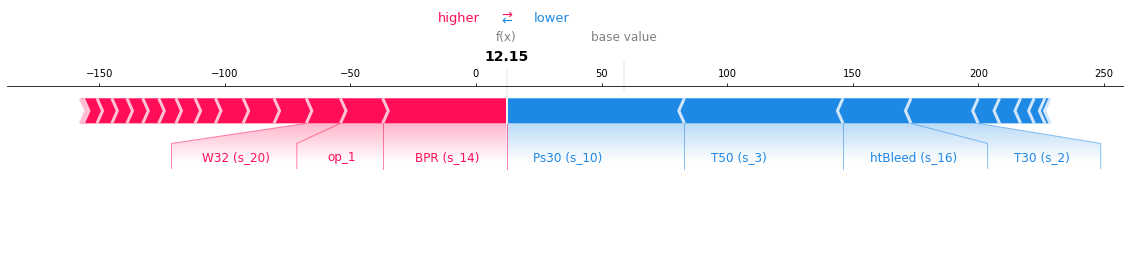

In [82]:
shap.force_plot(explainer.expected_value, shap_values[8471], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()

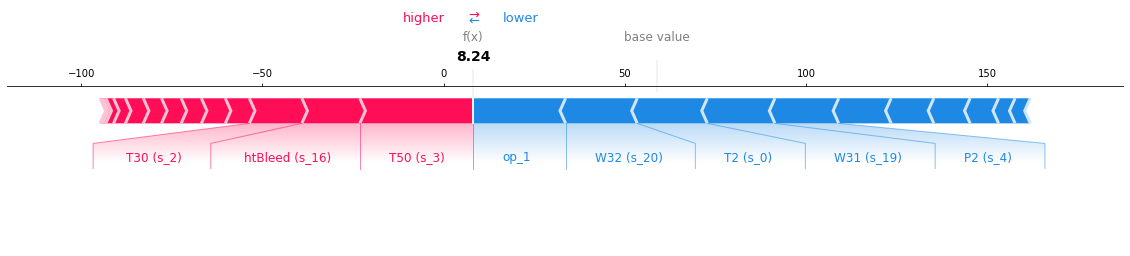

In [83]:
shap.force_plot(explainer.expected_value, shap_values[8472], 
                feature_names=feature_names, matplotlib=True, show=False)
# plt.savefig(f'{datetime.now()}.png', format='png', bbox_inches='tight')
plt.show()